# Image reconstruction in X-ray tomography
* Authors: Mengda Li, Ségolène Martin

## 1. X-ray tomography

The measurements $y \in R^M$ and the sought absorption image $\bar{x} \in R^N$ obey the linear relation:
$$y = H \bar{x} + w\tag{1}$$
where $w ∈ R^M$ is the measurement noise, that we assume i.i.d. Gaussian with variance $σ^2$. The tomography matrix $H ∈R^{M×N}$ is sparse and encodes the geometry of the measurements.

1. Download the projection matrix $H$ and the image $\bar{x}$ available on the website. Use `loadmat` from `scipy.io` in Python to load the arrays, note that $H$ is stored as a sparse matrix. 

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
from scipy.sparse import csr_matrix
from scipy.linalg import norm
import time

p = Path('data')
MATRICES = dict()
for matrix in p.iterdir():
    matrix_name = matrix.name[0]
    MATRICES[matrix_name] = sio.loadmat(matrix)

H = MATRICES['H']['H']
x = MATRICES['x']['x']
M, N = H.shape

H = csr_matrix(H)
x = x.reshape(N)

2. Construct $y$, according to model (1), using $σ = 1$.

In [139]:
# sigma = 1
w = np.random.normal(size = M)
y = H @ x + w

3. Here, $N = 90×90$ pixels and $M = 90×180$ measurements. Display a 2D version of $x$ and a 2D version of $y$, also known as sinogram.

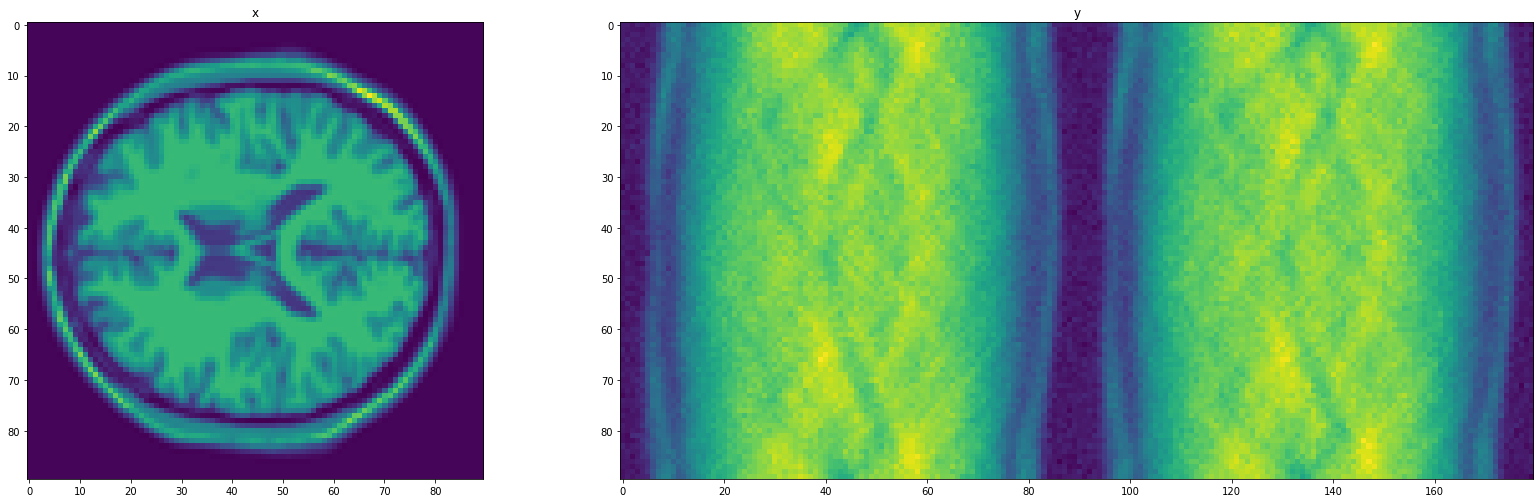

In [140]:
# plt.figure(figsize = (27,9))
plt.rcParams["figure.figsize"] = (27,9)
_, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
a0.imshow(np.reshape(x, (90, 90)))
a0.set_title('x')
a1.imshow(np.reshape(y, (90, 180)))
a1.set_title('y');

## 2. Optimization problem

An eﬃcient strategy to address the reconstruction problem is to deﬁne $x $as a minimizer of an appropriate cost function $f$. More speciﬁcally, we focus on the following penalized least-squares criterion :
$$\forall x  ∈R^N, \ f(x) =
\frac{1}{2}∥Hx−y∥^2 + λr(x) \tag{2} $$

where $r$ is a regularization function incorporating a priori assumptions to guarantee the robustness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we set
$$∀x ∈R^N, \ r(x) =
 ∑^{2N}_{n=1}
ψ([Gx]^{(n)}) \tag{3}
$$

where $G ∈R^{2N×N}$ is a sparse matrix such that $Gx ∈R^{2N}$ is the concatenation of the horizontal and vertical gradients of the image, and $ψ$ is a potential function deﬁned as : 
$$∀u ∈R, \ ψ(u) =\sqrt{1 + u^2/δ^2}  \tag{4}$$
with some parameter $δ > 0$ aiming at guaranteeing the diﬀerentiability of $r$. In the following, we will set $(λ,δ) = (0.13,0.02)$.

1. Download the gradient operator $G$ available in the website.

In [141]:
G = MATRICES['G']['G']
G = csr_matrix(G)

2. Give the expression of the gradient $∇f$ at some point $x ∈ R^N$. Create a function which gives as an output the gradient of $f$ at some input vector $x$.

<!-- In fact, the gradient $\nabla f$ here is the jacobian of $f$. -->
$$\nabla{f}(x) = H^TH x - H^Ty + \lambda \nabla{r}(x)$$
Let ${(e_n)_{n \in [1 .. 2N]}}$ be the canonical vector basis in $\mathbb{R}^{2N}$, 

<!-- $$
\begin{aligned}
 AR(p): Y_i &= c + \epsilon_i + \phi_i Y_{i-1} \dots \\
 Y_{i} &= c + \phi_i Y_{i-1} \dots
\end{aligned}
$$
$$\nabla r(x)^T = \sum_{n = 1}^{2N} \psi'(e_n^T G x) e_n^T G $$ -->

$$
\begin{aligned}
r(x) &= \sum_{n = 1}^{2N} \psi(e_n^T G x) \\
\nabla r(x)^T &= \sum_{n = 1}^{2N} \psi'(e_n^T G x) e_n^T G
\end{aligned}
$$
where $\psi'(u) = \frac{u}{\delta^2 \sqrt{1+\frac{u^2}{\delta^2} }}$.

so $$\nabla{f}(x)^T = x^T H^TH - y^TH + 
\lambda \sum_{n = 1}^{2N}\frac{e_n^T G x}{\delta^2 \sqrt{1+\frac{(e_n^T G x)^2}{\delta^2} }} e_n^T G $$
$$
\nabla{f}(x) = H^TH x - H^Ty + 
\lambda \sum_{n = 1}^{2N}\frac{[G x]^{(n)}}{\delta^2 \sqrt{1+\frac{([G x]^{(n)})^2}{\delta^2} }} [G]^{(n)}
$$
where $[G]^{(n)}$ is the vector of the $n$-th row of $G$.

In [142]:
LAMBDA, DELTA = 0.13, 0.02
DELTA2 = DELTA**2
Hy = H.T @ y
HH = H.T @ H

def grad_f(x):
    def grad_r(x):
        def dev_psi(u: np.array):
            return u / (DELTA2 * np.sqrt(1 + u**2 / DELTA2))
        Gx = G @ x
#         vec =  Gx / (DELTA2 * np.sqrt(1 + Gx**2 / DELTA2))
        return G.T @ dev_psi(Gx) #dev_psi(Gx).T * G
#     return HH * x - Hy + LAMBDA * grad_r(x)
    return H.T @ (H @ x) - Hy + LAMBDA * grad_r(x)

3. Show that a Lipschitz constant of $∇f$ is
$$L = ∥H∥^2 + (\lambda / \delta^2) ∥G∥^2$$
Calculate it for the $(\lambda, \delta^2)$ values given above. Note that,  in Python, the function
`scipy.sparse.linalg.svds` gives the singular values of a sparse matrix, the
maximal singular value being the norm of the matrix.

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$
Let $R(x,x') = \lambda \norm{\nabla r(x) - \nabla r(x')}$,
$$
\begin{aligned}
\forall x, x' \in \mathbb{R}^N, \ 
\norm{ \nabla f(x) - \nabla f(x')} &\leq \norm{H^TH (x-x')} + R(x,x') \\
& \leq \norm{H^TH} \norm{(x-x')}+ R(x,x') \\
& \leq \norm{H^T}\norm{H}\norm{(x-x')} + R(x,x') \\
& = \norm{H}^2\norm{(x-x')} + R(x,x')
\end{aligned}
$$
For the last equality, $H$ and $H^T$ have the same euclidean norm because they have the same singular values. The largest singular value is the euclidean matrix norm.

It remains to give an upper bound on $R(x,x')$, so let us find an upper bound of $\nabla^2 r(x)$:
$$
\begin{aligned}
\forall x \in \mathbb{R}^N, \ 
\nabla^2r(x) &= \sum_{n=1}^{2N} G^T e_n \psi''(e_n^T Gx)e_n^T G \\
            &= G^T \texttt{diag}\left(\psi''([Gx]^{(n)}) \right)G 
\end{aligned}
$$
Because $\sum_{n=1}^{2N} e_n e_n^T = Id$.

Then we need to majorize $\psi''([Gx]^{(n)})$ where $\psi''(u) = \frac{1}{\sqrt{\frac{u^2}{δ^2} + 1} \left(δ^2 + u^2 \right)}$.

$\psi: u \mapsto \sqrt{1+u^2/\delta^2}$ verifies the conditions of the even differentiable function lemma:
* $ψ$ is differentiable on $]0,+∞[$,
* $ψ(√·) = \sqrt{1 + ·\ /\delta^2}$ is concave on $]0,+∞[$,
* $∀x ∈ [0,+∞[, \ ψ'(x) = \frac{x}{\delta^2 \sqrt{1+\frac{x^2}{\delta^2} }} ≥ 0$,
* $\lim_{\begin{smallmatrix} x \to 0 & \\ x>0 \end{smallmatrix}} \left(ω(x) := \frac{ψ'(x)}{x} = \frac{1}{\delta^2 \sqrt{1+\frac{x^2}{\delta^2} }} \right) = \frac{1}{\delta^2 }∈ R$

and $∀x ∈ R, \ \psi(x) = \psi(|x|)$. So for all $y ∈ R$,
$$(∀x ∈ R), \ ψ (x) ≤ ψ (y) + ψ'(y)(x − y) +
\frac{ω(|y|)}{2}(x − y)^2$$
Then $$(ψ'(x) - ψ'(y)) (x − y) \le \frac{ω(y) + ω(x)}{2}(x − y)^2 \tag{$ω(x) = ω(|x|)$}$$
We can deduce that $$\psi''(x) \leq \omega(x) \quad \forall x \in \mathbb{R}^N$$
So $$
\begin{aligned}
\forall x \in \mathbb{R}^N, \ 
\nabla^2r(x) &= G^T \texttt{diag}\left(\psi''([Gx]^{(n)}) \right)G \\
&\leq G^T \Delta \left(Gx \right)G
\end{aligned}
$$
where $\Delta(x) = \text{diag}\left( \omega(x_i)_{i \in [1..N]}\right) =   \begin{bmatrix}
    \frac{1}{\delta^2 \sqrt{1+\frac{x_1^2}{\delta^2} }}  & & \\
    & \ddots & \\
    & & \frac{1}{\delta^2 \sqrt{1+\frac{x_N^2}{\delta^2} }}
  \end{bmatrix}$

Fortunately, $\max_x \frac{1}{\delta^2 \sqrt{1+\frac{x^2}{\delta^2} }} = \frac{1}{\delta^2}$ with $\arg\max = 0$. So $\Delta(x) \preceq \frac{1}{\delta^2} Id$.

Finally, we proved $\nabla^2 r(x) \preceq \frac{1}{\delta^2} G^T G, \quad \forall x\in \mathbb{R}^N$ which implies the following descent lemma on $r$:
$$
\begin{aligned}
\forall x\in \mathbb{R}^N, \
(∀y ∈ \mathbb{R}^N) \quad r(y) &\le r(x) + \langle y − x | ∇r(x) \rangle + \frac{1}{2\delta^2}(x − y)^T G^TG(x − y)\\
 &\le r(x) + \langle y − x | ∇r(x) \rangle + \frac{1}{2\delta^2}\|G\|^2 (x − y)^T (x − y)
\end{aligned}
$$
Because $\|G\|^2$ is the largest absolute eignvalue of $G^TG$.

This descent lemma implies that $\nabla r$ is $\frac{\|G\|^2}{\delta^2}$-Lipschitz continuous which means $\nabla f$ is $(\|H\|^2 + \frac{\lambda}{\delta^2}\|G\|^2)$-Lipschitz continuous.

In [143]:
from scipy.sparse.linalg import svds
L = ( svds(H, k = 1)[1] + (LAMBDA/DELTA2) * svds(G, k = 1)[1] )[0]

## 3. Optimization algorithms

### 3.1 Gradient descent algorithm

1. Create $x_0 \in R^N$ a vector with all entries equal to $0$. This will be our initialization for all tested algorithms.

In [144]:
x_0 = np.zeros(N) 

2. Implement a gradient descent algorithm to minimize $f$.

Note that $\psi''(u) > 0$ so $f$ is convex.

In [168]:

def line_search(f,
                x: "starting point in the feasible domain of f",
                Delta_x: "descent direction",
                gradient_f_x: "gradient of f at x",
                initial_step = 2/L,
                a = 0.25,
                b=0.5
#                 Steps = np.array([1e-1, 0.25, 0.5, 0.75, 0.99]) * 2/L
    ) -> "step size":
    """Backtracking line search."""
#     Candidate_values = np.array([f(x + t*Delta_x) for t in Steps])
#     return Steps[np.argmin(Candidate_values)]
    t = initial_step
    while f(x + t*Delta_x) > f(x) + a*t*gradient_f_x @ Delta_x:
        t = b*t
    return t

def grad_descent(
        f: "convex function to be minimized",
        gradient_f: "function to compute the gradient of f at some point x",
        x: "starting point in the strictly feasible domain of f",
        e: "tolerance, >0",
    list_values = False ) -> "argmin f":
    """Gradient descent method."""
    
    counter = 0
    v = []
    start_time = time.time()
    
    while True:
        Grad_f_x = gradient_f(x)
        criterion = norm(Grad_f_x)
        if criterion < e:
            temps = time.time() - start_time
            print("{} iterations, gradient norm is {}, elapsed time {:f}".format(counter, criterion, temps))
            if list_values == True:
                return [v, temps]
            else :
                return x

        search_direction =  -Grad_f_x #pas de - ??mais ca marche?!
        
        t = line_search(f, x, search_direction, Grad_f_x)
#         print(t)
        x = x + t*search_direction
        if list_values == True:
                v.append(f(x))
        
        counter+=1
        if counter%100 == 0:
            print("{} iterations, gradient norm is {}, elapsed time {:f}".format(counter, criterion, time.time() - start_time))

In [146]:
yy = y @ y
def f(x):
    def r(x):
        def psi(u: np.array):
            return np.sqrt(1 + u**2/DELTA2)
        Gx = G @ x
        return np.sum(psi(Gx))
    Hx = H @ x
    return 1/2 * (Hx @ Hx -2* x@Hy + yy) + LAMBDA * r(x)
    
TOLERANCE = np.sqrt(N) * 1e-4

In [255]:
optimum_gd = grad_descent(f, grad_f, x_0, TOLERANCE)            

100 iterations, gradient norm is 13.566078395961254, elapsed time 4.475609
200 iterations, gradient norm is 2.602730612240829, elapsed time 9.233105
300 iterations, gradient norm is 1.5072307528841367, elapsed time 13.891685
400 iterations, gradient norm is 0.0773996207931491, elapsed time 18.804998
500 iterations, gradient norm is 0.11341735226520352, elapsed time 24.437240
600 iterations, gradient norm is 0.015056107909622685, elapsed time 28.861518
607 iteraions, gradient norm is 0.008014473590000824, elapsed time 29.230328


### 3.2 MM quadratic algorithm

1. Construct, for all $x \in R^N$, a quadratic majorant function of $f$ at $x$. Create
a function which gives, as an output, the curvature $A(x)$ of the majorant
function at an input vector $x$.

Hint :  in Python,
use `scipy.sparse.diags(d[:,0]).tocsc()` to create a sparse matrix from a
diagonal vector $d \in R^{n \times 1}$ using the compressed sparse column format. In addition, in Python, use the class `LinearOperator` from `scipy.sparse.linalg`
to create the curvature operator.

<!-- I proved the curvature $A(x)$ of majorization in the question.   -->
From the answer of the question`2.3`:
$$
\begin{aligned}
\forall x \in \mathbb{R}^N, \ 
\nabla^2r(x) &= G^T \text{diag}\left(\psi''([Gx]^{(n)}) \right)G \\
&\leq G^T \Delta \left(Gx \right)G
\end{aligned}
$$
where $\Delta(x) = \text{diag}\left( \omega(x_i)_{i \in [1..N]}\right) =   \begin{bmatrix}
    \frac{1}{\delta^2 \sqrt{1+\frac{x_1^2}{\delta^2} }}  & & \\
    & \ddots & \\
    & & \frac{1}{\delta^2 \sqrt{1+\frac{x_N^2}{\delta^2} }}
  \end{bmatrix}$
  
So $$
\begin{aligned}
\forall x \in \mathbb{R}^N, \ 
\nabla^2 f(x) &= H^TH + \nabla^2r(x) \\
                &\leq \underbrace{H^TH + G^T \Delta \left(Gx \right)G}_{A(x)}
\end{aligned}
$$                
We can hence build a quadratic majorization function $h$ of $f$ by setting
$$(∀x ∈ \mathbb{R}^N) \ h(x, y) = f (y) + \langle ∇f (y)|x − y \rangle+
\frac{1}{2}\lVert x − y \rVert^2
_{A(y)}
$$
For all $y\in R^N$, we have $∀x ∈ \mathbb{R}^N, \ h(x, y) \ge f(x)$

In [147]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator
from functools import partial

def A(x):
    def Delta(u: np.array):
        def dev_psi_over_u(u: np.array):
            return 1 / (DELTA2 * np.sqrt(1 + u**2 / DELTA2))
#         flatten = (dev_psi_div_u(u)).reshape(2*N)
        return diags(dev_psi_over_u(u))
    Gx = G @ x
    def Ax_u(Gx, u):
        return H.T @ (H @ u) + LAMBDA * G.T @ (Delta(Gx) @ (G @ u))
    matvec = partial(Ax_u, Gx)
    
    return LinearOperator((N, N), matvec = matvec, rmatvec = matvec)

2. Deduce a MM quadratic algorithm to minimize $f$. Implement it.

Hint : in
Python, use `bicg` from `scipy.sparse.linalg`.

In [164]:
from scipy.sparse.linalg import bicg

def MM(f = f,
       gradient_f = grad_f, 
    x_0 = x_0,
      TOLERANCE = TOLERANCE,
      list_values = False ):
    
    x = x_0
    v = []
    counter = 0
    start_time = time.time()
    while True:
        Grad_f_x = gradient_f(x)
        criterion = norm(Grad_f_x)
        if criterion < TOLERANCE:
            temps = time.time() - start_time
            print("{} iterations, gradient norm is {}, elapsed time {:f}".format(counter, criterion, temps))
            if list_values == True:
                return [v, temps]
            else :
                return x

        search_direction =  -bicg(A(x), Grad_f_x)[0] 
        
        t = line_search(f, x, search_direction, Grad_f_x, initial_step=2)
        x = x + t*search_direction
        if list_values == True:
                v.append(f(x))

        counter+=1
        #print("{} iterations, gradient norm is {}, elapsed time {:f}".format(counter, criterion, time.time() - start_time))    
        
        if counter%100 == 0:
            print("{} iterations, gradient norm is {}, elapsed time {:f}".format(counter, criterion, time.time() - start_time))    

In [134]:
optimum_MM = MM()

39 iterations, gradient norm is 0.008279219977985296, elapsed time 21.457356


_Remark_: The relative error between the optimums obtained by 2 different algorithms is relatively small:

In [27]:
np.max(np.abs(optimum_MM- optimum_gd))

0.00012797131432584763

### 3.3 3MG algorithm

1. Implement the 3MG algorithm.

Hint : use `scipy.linalg.pinv` in Python to compute the
pseudo-inverse. Given the size of the matrices, mind the order of matrix multiplications, e.g. when computing 
$D_k^⊤  H^⊤HD_k$ do not compute 
$D_k^⊤(H^⊤H)D_k$
but $(HD_k)^⊤(HD_k)$.

In [166]:
from scipy.linalg import pinv

def MM_MG(f = f,
       gradient_f = grad_f, 
    x_0 = x_0,
      TOLERANCE = TOLERANCE,
         list_values = False):
    
    counter = 0
    start_time = time.time()
    
    D = -gradient_f(x_0)
#     breakpoint()
    u = - 1/(D.T @ (A(x_0) @ D)) * (D.T @ D)
    step = u * D
    x = x_0 + step
    v = []
    
    while True:
        Grad_f_x = gradient_f(x)
        criterion = norm(Grad_f_x)
        if criterion < TOLERANCE:
            temps = time.time() - start_time
            print("{} iterations, gradient norm is {}, elapsed time {:f}".format(counter, criterion,temps))
            if list_values == True:
                return [v, temps]
            else :
                return x

        D = np.vstack((-Grad_f_x, step)).T
        u = -pinv(D.T @ (A(x) @ D)) @ (D.T @ Grad_f_x)
        step = D @ u
        x = x + step
        if list_values == True:
                v.append(f(x))

        counter+=1
        if counter%100 == 0:
            print("{} iteraions, gradient norm is {}, elapsed time {:f}".format(counter, criterion, time.time() - start_time))    

In [73]:
optimum_3MG = MM_MG()

100 iteraions, gradient norm is 0.27236162450495405, elapsed time 4.328557
144 iteraions, gradient norm is 0.008321832056903846, elapsed time 6.171874


_Remark_: The relative error between the optimums obtained by 3 different algorithms is relatively small and the error between 3MG and MM is much smaller.

In [74]:
np.max(np.abs(optimum_MM- optimum_3MG))

2.9771972229419852e-05

In [75]:
np.max(np.abs(optimum_gd- optimum_3MG))

0.0001311725707862088

### 3.4 Block-coordinate MM quadratic algorithm

1. Create a function which gives, as an output, matrix $A_j (x) \in \mathbb{R}^{N_j \times N_j}$ containing only the lines and rows of $A(x)$ with indexes $\mathbb{J}_j$.

In [150]:
def A_block(x, j, N_j):
    def Delta(u: np.array):
        def dev_psi_over_u(u: np.array):
            return 1 / (DELTA2 * np.sqrt(1 + u**2 / DELTA2))
#         flatten = (dev_psi_div_u(u)).reshape(2*N)
        return diags(dev_psi_over_u(u))
    Gx = G @ x
    def Ax_u(Gx, u):
        H_block = H[:,j*N_j: j*N_j+N_j]
        G_block = G[:,j*N_j: j*N_j+N_j]
        return H_block.T @ (H_block @ u) + LAMBDA * G_block.T @ (Delta(Gx) @ (G_block @ u))
    matvec = partial(Ax_u, Gx)
    
    return LinearOperator((N_j, N_j), matvec = matvec, rmatvec = matvec)

2. Deduce an implementation of a block coordinate MM quadratic algorithm for minimizing $f$. Test it for $N_j = N/K$ with $K \in \{1,2,3,5,6,9\}$.

In [167]:
from scipy.sparse.linalg import bicg

N_j = int(N/K)

def MM_block(f = f,
    gradient_f = grad_f, 
    x_0 = x_0,
    TOLERANCE = TOLERANCE, 
    K = 1, 
    list_values = False):
    
    N_j = int(N/K)
    x = x_0
    v = []
    counter = 0
    start_time = time.time()
    
    while True and counter<500:
        Grad_f_x = gradient_f(x)
        criterion = norm(Grad_f_x)
        
        if criterion < TOLERANCE:
            temps = time.time() - start_time
            print("K = {}, ran in {} iterations, gradient norm is {:15.14}, elapsed time {:f}".format(K, counter, criterion, temps))
            if list_values == True:
                return [v, temps]
            else :
                return x

        j = counter%K
        A_j = A_block(x, j, N_j)
        search_direction =  -bicg(A_j, Grad_f_x[j*N_j:j*N_j+N_j])[0]
        
        #line search
        search_direction_line_search =  np.zeros(N)
        search_direction_line_search[j*N_j:j*N_j+N_j] = search_direction
        t = line_search(f, x, search_direction_line_search, Grad_f_x, initial_step=2)
        x[j*N_j:j*N_j+N_j] += t*search_direction
        if list_values == True:
                v.append(f(x))
        counter+=1
    
        # print("K = {}, ran in {} iterations, gradient norm is {:15.14}, elapsed time {:f}".format(K, counter, criterion, time.time() - start_time))
        # if counter%100 == 0:
            # print("K = {}, ran in {} iterations, gradient norm is {:15.14}, elapsed time {:f}".format(K, counter, criterion, time.time() - start_time))    
            

In [126]:
for K in [1,2,3,5,6,9]:
    x_0 = np.zeros(N) 
    optimum_MM_block = MM_block(f, grad_f, x_0, TOLERANCE, K)

K = 1, ran in 39 iterations, gradient norm is 0.0082792199779853, elapsed time 41.913495
K = 2, ran in 91 iterations, gradient norm is 0.0081907561652613, elapsed time 101.786068
K = 3, ran in 141 iterations, gradient norm is 0.0066528792422554, elapsed time 117.180070
K = 5, ran in 247 iterations, gradient norm is 0.0089603094108915, elapsed time 142.243212
K = 6, ran in 272 iterations, gradient norm is 0.0080656500131019, elapsed time 126.526941
K = 9, ran in 421 iterations, gradient norm is 0.0082366117613391, elapsed time 155.583495


These results are not what we were expecting : the block coordinate strategy should have reduced the computation time, which is clearly not the case here. This might be because the function $\texttt{A_block}$ that was implemented is time-consuming (it requires to section matrices).

### 3.6 Comparaison of the methods

2. We will consider that the convergence is reached when the following stopping criterion is fulfilled :$$
\Vert \nabla f(x_k)\Vert \leq  \sqrt{N}\times 10 .$$
What is the required time for each method to achieve this condition? For each method, plot the decrease of $(f(x_k))_{k\in \mathbb{N}}$ versus time until the stopping criterion is satisfied.

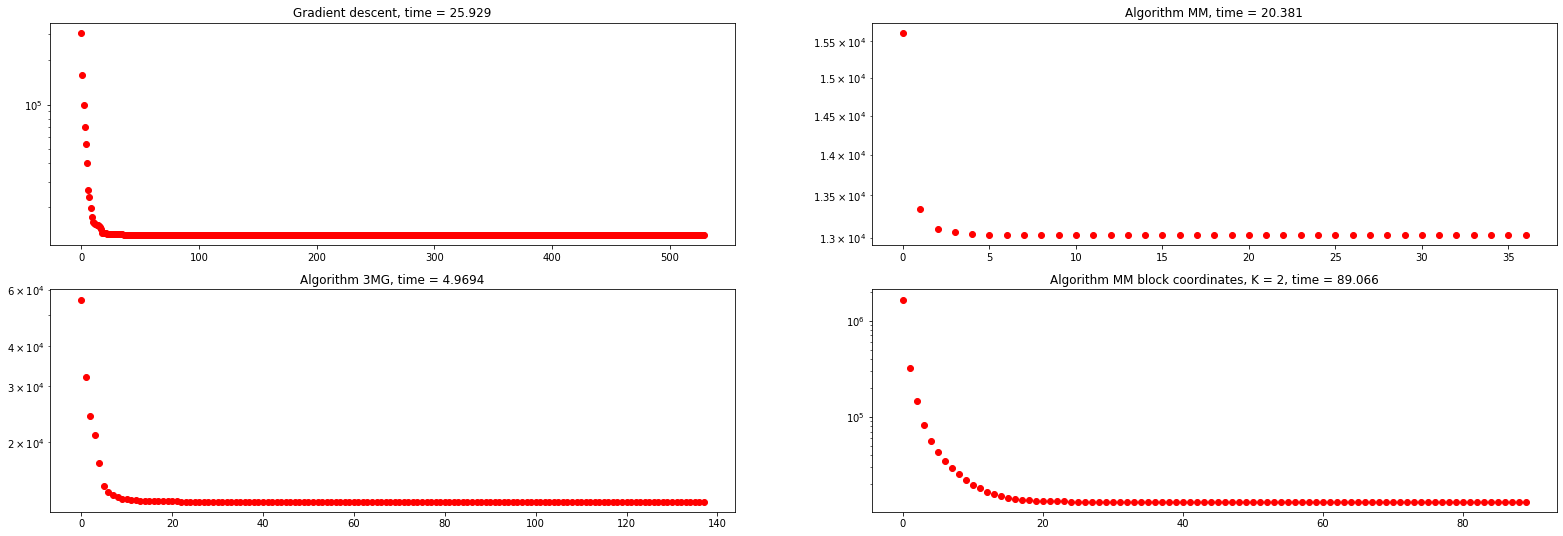

In [170]:
x_0 = np.zeros(N)
values_gd, time_gd = grad_descent(f, grad_f, x_0, TOLERANCE, list_values = True)
values_MM, time_MM = MM(f, grad_f, x_0, TOLERANCE, list_values = True)
values_3MG, time_3MG = MM_MG(f, grad_f, x_0, TOLERANCE, list_values = True)
values_MMblock, time_MMblock = MM_block(f, grad_f, x_0, TOLERANCE, 2, list_values = True)

plt.subplot(2,2,1)
plt.semilogy(values_gd, 'ro')
plt.title('Gradient descent, time = {:6.5}'.format(time_gd))

plt.subplot(2,2,2)
plt.semilogy(values_MM, 'ro')
plt.title('Algorithm MM, time = {:6.5}'.format(time_MM))

plt.subplot(2,2,3)
plt.semilogy(values_3MG, 'ro')
plt.title('Algorithm 3MG, time = {:6.5}'.format(time_3MG))

plt.subplot(2,2,4)
plt.semilogy(values_MMblock, 'ro')
plt.title('Algorithm MM block coordinates, K = 2, time = {:6.5}'.format(time_MMblock))

plt.show()


The 3MG algorithm achieves by far the best time (4 times faster than the MM algorithm) even though it needs more iterations to reach the criterion.

3. The Signal to Noise Ration (SNR) of a restored image $\hat{x}$ is defined as
$$SNR = 10 \log(\Vert \bar{x} \Vert^2 /\Vert\bar{x} - \hat{x} \Vert^2 )$$

Using the fastest method, search for parameters $\lambda, \delta$ that optimize the SNR.

In [177]:
def SNR(x, x_hat):
    return 10*np.log(x @ x / ((x - x_hat)@ (x - x_hat)))

In [183]:
x_0 = np.zeros(N)
list_delta = np.linspace(0.01, 0.03, 10)
list_lambda = np.linspace(0.05, 0.2, 10)

SNR_min = 1e6

for i, DELTA in enumerate(list_delta):
    DELTA2 = DELTA**2
    for j, LAMBDA in enumerate(list_lambda):
        L = ( svds(H, k = 1)[1] + (LAMBDA/DELTA2) * svds(G, k = 1)[1] )[0]
        x_hat = MM_MG(f = f, gradient_f = grad_f, x_0 = x_0, TOLERANCE = TOLERANCE)
        SNR_present = SNR(x, x_hat)
        
        if SNR_present < SNR_min:
            SNR_min = SNR_present
            i_min = i
            j_min = j
            

100 iteraions, gradient norm is 0.37283886556024737, elapsed time 3.121464
154 iterations, gradient norm is 0.008564224741697362, elapsed time 4.880930
100 iteraions, gradient norm is 0.280363085711415, elapsed time 3.133506
149 iterations, gradient norm is 0.008556684377227708, elapsed time 4.674538
100 iteraions, gradient norm is 0.23178183794356336, elapsed time 3.126652
145 iterations, gradient norm is 0.00892656792786668, elapsed time 4.539948
100 iteraions, gradient norm is 0.21145499204072907, elapsed time 3.124155
144 iterations, gradient norm is 0.008849514366913249, elapsed time 4.495896
100 iteraions, gradient norm is 0.2226417907888589, elapsed time 3.275800
150 iterations, gradient norm is 0.008487742097240902, elapsed time 4.955393
100 iteraions, gradient norm is 0.2782492726309173, elapsed time 3.132419
160 iterations, gradient norm is 0.008720622347559699, elapsed time 5.032713
100 iteraions, gradient norm is 0.33506482186743997, elapsed time 3.106340
165 iterations, gr

142 iterations, gradient norm is 0.008215038897332676, elapsed time 4.426540
100 iteraions, gradient norm is 0.18060850142926785, elapsed time 3.130269
138 iterations, gradient norm is 0.008194296442758965, elapsed time 4.314514
100 iteraions, gradient norm is 0.16250944373464593, elapsed time 3.104466
134 iterations, gradient norm is 0.008908787700075322, elapsed time 4.163784
100 iteraions, gradient norm is 0.13849224084752987, elapsed time 3.117680
131 iterations, gradient norm is 0.00883546983355758, elapsed time 4.085001
100 iteraions, gradient norm is 0.11600394016366318, elapsed time 3.112990
129 iterations, gradient norm is 0.008998939420350375, elapsed time 4.015694
100 iteraions, gradient norm is 0.09720903549112413, elapsed time 3.099888
127 iterations, gradient norm is 0.008734443052384617, elapsed time 3.951645
100 iteraions, gradient norm is 1.5136518439176392, elapsed time 3.093800
197 iterations, gradient norm is 0.007991789480806295, elapsed time 6.085617
100 iteraions

In [184]:
print('Best SNR achieved is {} with lambda = {}, delta = {}'.format(SNR_min, list_lambda[j_min],list_delta[i_min]) )

Best SNR achieved is 35.88294884679199 with lambda = 0.05, delta = 0.03
